# Simple Recurrent Language Model

Predicting the next token.

# Imports and Setup

Common imports and standardized code for importing the relevant data, models, etc., in order to minimize copy-paste/typo errors.


Set the relevant text field (`'abstract'` or `'title'`) and whether we are working with `'one-hot'` or `'tokenized'` text.  

In [ ]:
TEXT_FIELD = 'abstract'
TEXT_ENCODING = 'tokenized'
assert TEXT_FIELD in ('abstract', 'title'), 'TEXT_FIELD must be one of "title" or "abstract".'
assert TEXT_ENCODING in ('one-hot', 'tokenized'), 'TEXT_ENCODING must be one of "one-hot" or "tokenized".'
# The above choices determine the relevant sequence length of the data.
SEQ_LEN = 128 if TEXT_ENCODING == 'tokenized' else 2048

Imports and colab setup

In [ ]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab for arxiv_vixra_models
!pip install wandb
!pip install pytorch-lightning
!pip install unidecode
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option(u'float_format', '{:f}'.format)
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import seaborn as sns
import torch
import wandb

`wandb` log in:

In [ ]:
wandb.login()

wandb: Currently logged in as: garrett361 (use `wandb login --relogin` to force relogin)


True

Google drive access

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing modules stored in FOLDERNAME or a subdirectory thereof:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


Import my models, loaders, and utility functions:

In [ ]:
import arxiv_vixra_models as avm

Set the model, datamodule, and text utils to be instantianted in the notebook

In [ ]:
notebook_model = avm.LitEmbeddingRNNNextLM
notebook_datamodule = avm.EmbeddingDataModuleNextLM
notebook_encoder = avm.string_to_idxs 
notebook_decoder = avm.idxs_to_string 
notebook_wandb_callback = avm.WandbAVPredictionCallback

Copy data to cwd for speed.

In [ ]:
train_data_file_name = 'large_filtered_normalized_data_train.feather'
val_data_file_name = 'balanced_filtered_normalized_data_validation.feather'
SUBDIR = '/data/data_splits/'
train_data_path = FOLDERNAME + SUBDIR + train_data_file_name
val_data_path = FOLDERNAME + SUBDIR + val_data_file_name
if TEXT_ENCODING == 'one-hot':
    tokens_file_name = 'normalized_char_set.feather'
else:
    tokens_file_name = 'balanced_title_normalized_vocab.feather'
tokens_path = FOLDERNAME + SUBDIR + tokens_file_name
!cp '{train_data_path}' .
!cp '{val_data_path}' .
!cp '{tokens_path}' .
train_data_df = pd.read_feather(train_data_file_name)
val_data_df = pd.read_feather(val_data_file_name)
tokens_df = pd.read_feather(tokens_file_name)
if TEXT_ENCODING == 'one-hot':
    text_to_idx = dict(zip(tokens_df.char.values, np.arange(len(tokens_df))))
else:
    # 0 and 1 are reserved for padding and <UNK> for embeddings and not included
    # in tokens_df
    text_to_idx = dict(zip(tokens_df.word.values, np.arange(2, len(tokens_df) + 2)))
    text_to_idx['<PAD>'] = 0
    text_to_idx['<UNK>'] = 1
idx_to_text = {val: key for key, val in text_to_idx.items()}
if TEXT_FIELD == 'title':
    train_text_file_name = 'concatenated_large_normalized_train_title.txt'
    val_text_file_name = 'concatenated_balanced_normalized_validation_title.txt'
else:
    train_text_file_name = 'concatenated_large_normalized_train_abstract.txt'
    val_text_file_name = 'concatenated_balanced_normalized_validation_abstract.txt'
with open(FOLDERNAME + SUBDIR + train_text_file_name, 'r') as f:
    train_text = f.read().strip()
with open(FOLDERNAME + SUBDIR + val_text_file_name, 'r') as f:
    val_text = f.read().strip()

Computing specs. Save the number of processors to pass as `num_workers` into the Datamodule and cuda availability for other flags.

In [ ]:
# GPU. Save availability to IS_CUDA_AVAILABLE.
gpu_info= !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  IS_CUDA_AVAILABLE = False
else:
  print(f"GPU\n{50 * '-'}\n", gpu_info, '\n')
  IS_CUDA_AVAILABLE = True

# Memory.
from psutil import virtual_memory, cpu_count
ram_gb = virtual_memory().total / 1e9
print(f"Memory\n{50 * '-'}\n", 'Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), '\n')

# CPU.
print(f"CPU\n{50 * '-'}\n", f'CPU Processors: {cpu_count()}')
# Determine the number of workers to use in the datamodule
NUM_PROCESSORS = cpu_count()

GPU
--------------------------------------------------
 Fri Jan 14 05:12:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                

Use notebook name as `wandb` `project` string. Remove the file extension and any "Copy of" or "Kopie van" text which arises from copying notebooks and running in parallel. The `entity` needed for various `wandb` calls is just the `wandb` user name.

In [ ]:
from requests import get
PROJECT = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
PROJECT = PROJECT.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(PROJECT)
ENTITY = 'garrett361'

large_abstract_recurrent_embedding_next_language_model


# Loading Best GloVe Embeddings

We will use the pre-trained embedding in our network.

In [ ]:
wandb_api = wandb.Api()
GLOVE_PROJECT = 'large_abstract_glove'
glove_runs = wandb_api.runs(ENTITY + "/" + GLOVE_PROJECT) 

run_cats = ('best_loss','config', 'name', 'wandb_path')
glove_runs_dict = {key: [] for key in run_cats}

for run in glove_runs:
    run_json = run.summary._json_dict
    if 'best_loss' in run_json:
        glove_runs_dict['best_loss'].append(run_json['best_loss'])
        glove_runs_dict['config'].append({key: val for key, val in run.config.items()})
        glove_runs_dict['name'].append(run.name)
        glove_runs_dict['wandb_path'].append('/'.join(run.path))
    
glove_runs_df = pd.DataFrame(glove_runs_dict).sort_values(by='best_loss', ascending=True).reset_index(drop=True)
glove_runs_df.head()

,best_loss,config,name,wandb_path
0,0.024557,"{'lr': 0.1, 'alpha': 0.75, 'x_max': 100, 'batc...",lr_0.1_scheduler_plateau,garrett361/large_abstract_glove/1pzvqhun
1,0.024748,"{'lr': 0.1, 'alpha': 0.75, 'x_max': 100, 'batc...",lr_0.1_scheduler_plateau,garrett361/large_abstract_glove/3ify2tmz
2,0.025020,"{'lr': 0.1, 'alpha': 0.75, 'x_max': 100, 'batc...",lr_0.1_scheduler_plateau,garrett361/large_abstract_glove/2ltjoose
3,0.025737,"{'alpha': 0.75, 'x_max': 100, 'pin_memory': Tr...",lr_0.1_scheduler_plateau,garrett361/large_abstract_glove/1l52vw5e
4,0.026800,"{'lr': 0.2, 'alpha': 0.75, 'x_max': 100, 'batc...",lr_0.2_scheduler_plateau,garrett361/large_abstract_glove/17f31pap


In [ ]:
best_glove_df = glove_runs_df.iloc[glove_runs_df['best_loss'].argmin()]
print(best_glove_df)

best_loss                                              0.024557
config        {'lr': 0.1, 'alpha': 0.75, 'x_max': 100, 'batc...
name                                   lr_0.1_scheduler_plateau
wandb_path             garrett361/large_abstract_glove/1pzvqhun
Name: 0, dtype: object


Save the state dicts locally and rebuild the corresponding models.

In [ ]:
# wandb stores None values in the config dict as a string literal. Need to
# fix these entries, annoyingly.
for key, val in best_glove_df.config.items():
    if val == 'None':
        best_glove_df.config[key] = None
# Write to disk
glove_file_name = f"glove_dim_{best_glove_df.config['embedding_dim']}.pt"
wandb.restore(glove_file_name,
              run_path=best_glove_df.wandb_path,
              replace=True)
glove_state_dict = torch.load(glove_file_name)
glove_embedding_weights = (glove_state_dict['word_embedding.weight'] + glove_state_dict['context_embedding.weight']) / 2

# Model Testing

Setting hyperparameters and performing a small test run.

Dictionary args for model and datamodule.

In [ ]:
model_args_dict = {'seq_len': SEQ_LEN,
                  'tokens': tokens_df,
                  'num_layers': 2,
                  'hidden_size': 512,
                  'embedding_dim': best_glove_df.config['embedding_dim'],
                  'rnn_type': 'GRU',
                  'fc_dims': None,
                  'zero_fc_bias_init': True,
                  'truncated_bptt_steps': 32,
                  'embedding_from_pretrained': glove_embedding_weights.cpu()
                  }

data_args_dict = {'seq_len': SEQ_LEN,
                 'train_text': train_text,
                 'val_text': val_text,
                 'tokens': tokens_df, 
                 'num_workers': NUM_PROCESSORS,
                 'batch_size': 128,
                 'pin_memory': IS_CUDA_AVAILABLE,
                 'persistent_workers': True,
                 }

Small test run.

In [ ]:
small_data_module = notebook_datamodule(**data_args_dict)
small_data_module.setup()
small_loader = small_data_module.train_dataloader()
small_inputs, small_targets = next(iter(small_loader))
# Print the first few input texts
for input, target in  zip(small_inputs[:3], small_targets[:3]):
    sample_text = notebook_decoder(input, idx_to_text, replace_pad_with_space=True)
    sample_target = notebook_decoder(target, idx_to_text, replace_pad_with_space=True)
    print(f"input  text: {sample_text}",
          f"target text: {sample_target}",
          f'input, target tensor lens: {len(input), len(target)}',
          sep='\n')
small_model = notebook_model(**model_args_dict)
print('Model layers:', small_model)
small_preds, small_losses, _ = small_model.scores_loss_hiddens(small_inputs, small_targets)
print('\npreds shape:', small_preds.shape)
print('\nactual loss:', small_losses.item())
print('\nexpected approx loss', np.log(len(tokens_df)))

input  text: { 84 } } . \ ] route choice is often modelled as a two - step procedure in which <UNK> choose their routes from small sets of promising candidates . many methods developed to identify such choice sets <UNK> on assumptions about the mechanisms behind the route choice and require corresponding data sets . <UNK> , existing approaches often involve <UNK> complexity or <UNK> many repeated shortest path queries . this makes it difficult to apply these methods in comprehensive models with numerous origin - <UNK> pairs . in this paper , we address these issues by developing an algorithm that efficiently identifies locally optimal routes . such paths arise from <UNK> acting <UNK> on local scales , <UNK> unknown factors may affect the routes on larger
target text: 84 } } . \ ] route choice is often modelled as a two - step procedure in which <UNK> choose their routes from small sets of promising candidates . many methods developed to identify such choice sets <UNK> on assumptions ab

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.




preds shape: torch.Size([128, 23948, 128])

actual loss: 10.084165573120117

expected approx loss 10.08355657427679


In [ ]:
# pl implements gradient clipping through the Trainer.
small_trainer = Trainer(gpus=-1 if IS_CUDA_AVAILABLE else 0,
                        max_epochs=1,
                        gradient_clip_val=1
                        )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


A `LR finder stopped early due to diverging loss.` here may be due to having too large a batch size, i.e., not enough samples from the datamodule; [see this github discussion](https://github.com/PyTorchLightning/pytorch-lightning/issues/5044)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/lr_find_temp_model_be21d3c7-2382-4cc5-a918-2d8f6e2c64c5.ckpt


Suggested lr: 1287.943282347242815e-05


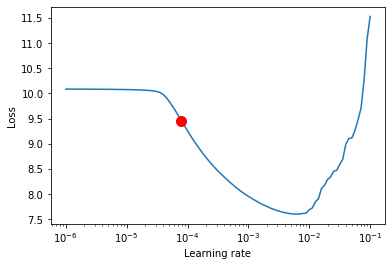

In [ ]:
small_trainer_lr_finder = small_trainer.tuner.lr_find(small_model, datamodule=small_data_module, min_lr=1e-6, max_lr=1e-1)
small_trainer_lr_finder_plot = small_trainer_lr_finder.plot(suggest=True)
small_trainer_suggested_lr = small_trainer_lr_finder.suggestion()
print(f'Suggested lr: 128{small_trainer_suggested_lr}')

# Training

In [ ]:
cyclic_lr_scheduler_args = {'base_lr': 5e-3,
                            'max_lr': 7e-2,
                            'step_size_up': 400,
                            'cycle_momentum': False}
plateau_lr_scheduler_args = {'verbose': True,
                             'patience': 50,
                             'factor': .75}

model_args_dict['save_models_to_wandb'] =True
model_args_dict['lr'] = 1e-3
model_args_dict['lr_scheduler'] = 'plateau'
model_args_dict['lr_scheduler_args'] = plateau_lr_scheduler_args
model_args_dict['lr_scheduler_monitor'] = 'train_batch_loss'
model = notebook_model(**model_args_dict)

data_args_dict['batch_size'] = 128
datamodule = notebook_datamodule(**data_args_dict)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.



Training:

In [ ]:
trainer = Trainer(logger=WandbLogger(),
                  gpus=-1 if IS_CUDA_AVAILABLE else 0,
                  log_every_n_steps=1,)
with wandb.init(project=PROJECT) as run:
    run.name = f"lr_{model.hparams['lr']}_scheduler_{model_args_dict.get('lr_scheduler', None)}"
    trainer.fit(model, datamodule=datamodule)
    plt.close("all")


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


  | Name               | Type       | Params
--------------------------------------------------
0 | train_metrics_dict | ModuleDict | 0     
1 | val_metrics_dict   | ModuleDict | 0     
2 | test_metrics_dict  | ModuleDict | 0     
3 | embedding          | Embedding  | 6.1 M 
4 | rnn                | GRU        | 2.8 M 
5 | fc_layers          | ModuleList | 12.3 M
--------------------------------------------------
15.0 M    Trainable params
6.1 M     Non-trainable params
21.2 M    Total params
84.699    Total estimated model params size (MB)


Validation sanity check: 0it [00:03, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 6.103515625e-05
Validation Loss: 10.086533546447754
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 6.103515625e-05
Validation Loss: 10.086533546447754


Training: 0it [00:00, ?it/s]

# Loading Best Models

In [ ]:
wandb_api = wandb.Api()
notebook_runs = wandb_api.runs(ENTITY + "/" + PROJECT) 

run_cats = ('best_loss','config', 'name', 'wandb_path')
notebook_runs_dict = {key: [] for key in run_cats}

for run in notebook_runs:
    run_json = run.summary._json_dict
    if 'best_loss' in run_json:
        notebook_runs_dict['best_loss'].append(run_json['best_loss'])
        notebook_runs_dict['config'].append({key: val for key, val in run.config.items()})
        notebook_runs_dict['name'].append(run.name)
        notebook_runs_dict['wandb_path'].append('/'.join(run.path))
    
notebook_runs_df = pd.DataFrame(notebook_runs_dict).sort_values(by='best_loss', ascending=True).reset_index(drop=True)
notebook_runs_df.head()

In [ ]:
best_model_df = notebook_runs_df.iloc[notebook_runs_df['best_loss'].argmin()]
print(best_model_df)

Save the state dicts locally and rebuild the corresponding models.

In [ ]:
# wandb stores None values in the config dict as a string literal. Need to
# fix these entries, annoyingly.
for key, val in best_model_df.config.items():
    if val == 'None':
        best_model_df.config[key] = None
# Write to disk
best_model_file_name = f"glove_dim_{best_model_df.config['embedding_dim']}.pt"
wandb.restore(best_model_file_name,
              run_path=best_model_df.wandb_path,
              replace=True)
best_model_file_name_suffix = '_'.join(best_model_file_name.split('_')[-2:])
# Also copy to the final_models folder
!cp '{best_model_file_name}' "{FOLDERNAME + '/final_models/' + PROJECT + '_' + best_model_file_name_suffix}"

In [ ]:
best_model = notebook_model(**{**best_model_df.config, **{'co_matrix': co_matrix}})
best_model.load_state_dict(torch.load(glove_file_name))

# Visualize

In [ ]:
heatmap = avm.embedding_cosine_heatmap(model=best_model,
                                       words=heatmap_words,
                                       word_to_idx=title_word_to_idx)

In [ ]:
pca = avm.pca_3d_embedding_plotter_topk(model=best_model,
                                     words=pca_words,
                                     word_to_idx=title_word_to_idx,
                                     idx_to_word=title_idx_to_word,
                                     title='PCA',
                                     k=5)

In [ ]:
tsne = avm.tsne_3d_embedding_plotter_topk(model=best_model,
                                     words=tsne_words,
                                     word_to_idx=title_word_to_idx,
                                     idx_to_word=title_idx_to_word,
                                     title='t-SNE',
                                     k=5)

In [ ]:
pca.show()

In [ ]:
tsne.show()

In [ ]:
avm.embedding_utils.topk_analogies_df(best_model,
                                      'newton mechanics heisenberg'.split(),
                                      title_word_to_idx,
                                      title_idx_to_word)